# VLB Startup Shear: NLSQ → NUTS

**PNAS Digital Rheometer Twin — startup shear at $\dot{\gamma}$ = 1 s⁻¹**

## Learning Objectives

- Fit startup stress $\sigma(t) = \eta_0 \dot{\gamma} (1 - e^{-k_d t})$
- Extract G₀ and k_d from transient shear data
- Understand why VLB shows no stress overshoot

## Data Source

PNAS 2022 Digital Rheometer Twin dataset (startup at 1 s⁻¹).

## Estimated Runtime

- Fast demo (1 chain): ~1 min
- Full run (4 chains): ~3 min

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings('ignore', category=FutureWarning)

# Tutorial utilities
import sys

sys.path.insert(0, str(Path('..').resolve()))
from utils.vlb_tutorial_utils import (
    get_bayesian_config,
    get_output_dir,
    load_pnas_startup,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
)

print(f"JAX version: {jax.__version__}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3


## 2. Load Experimental Data

Data points: 200
Time range: 0.005 - 600.0 s
Stress range: 0.69 - 26.1 Pa


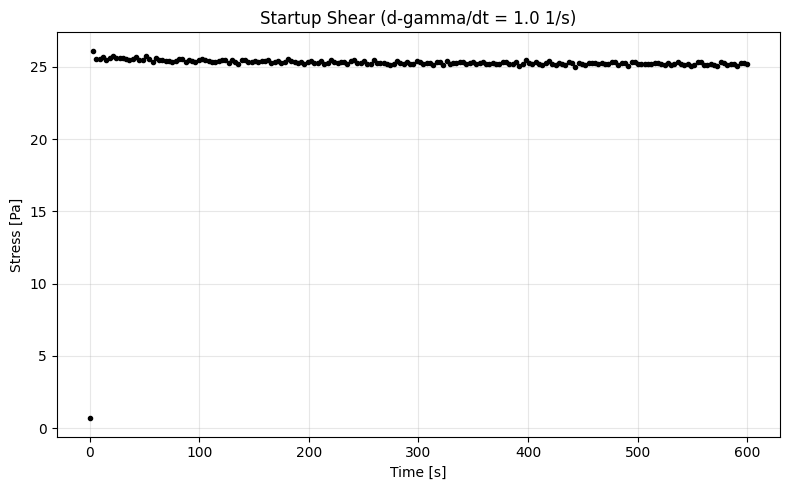

In [3]:
GAMMA_DOT = 1.0  # Applied shear rate [1/s]
time_data, stress_data = load_pnas_startup(GAMMA_DOT, max_points=200)

print(f'Data points: {len(time_data)}')
print(f'Time range: {time_data.min():.3f} - {time_data.max():.1f} s')
print(f'Stress range: {stress_data.min():.2f} - {stress_data.max():.1f} Pa')

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_data, stress_data, 'ko', markersize=3)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Stress [Pa]')
ax.set_title(f'Startup Shear (d-gamma/dt = {GAMMA_DOT} 1/s)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 3. VLB Forward Model

VLB startup stress under constant shear rate $\dot{\gamma}$:

$$\sigma(t) = \frac{G_0}{k_d} \dot{\gamma} \left(1 - e^{-k_d t}\right) = \eta_0 \dot{\gamma} \left(1 - e^{-t/t_R}\right)$$

- **No stress overshoot**: monotonic approach to steady state
- Steady-state stress: $\sigma_{\infty} = \eta_0 \dot{\gamma}$
- Rise time $\sim 3 t_R = 3/k_d$

## 4. Step 1: NLSQ Point Estimation

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.776649s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=14 | final_cost=0.0034 | elapsed=0.777s | final_gradient_norm=4.3592e-08


NLSQ fit time: 1.02 s
G0  = 130.95 Pa
k_d = 5.1741 1/s
eta_0 = 25.31 Pa*s
sigma_ss = 25.31 Pa
R-squared = 0.992736


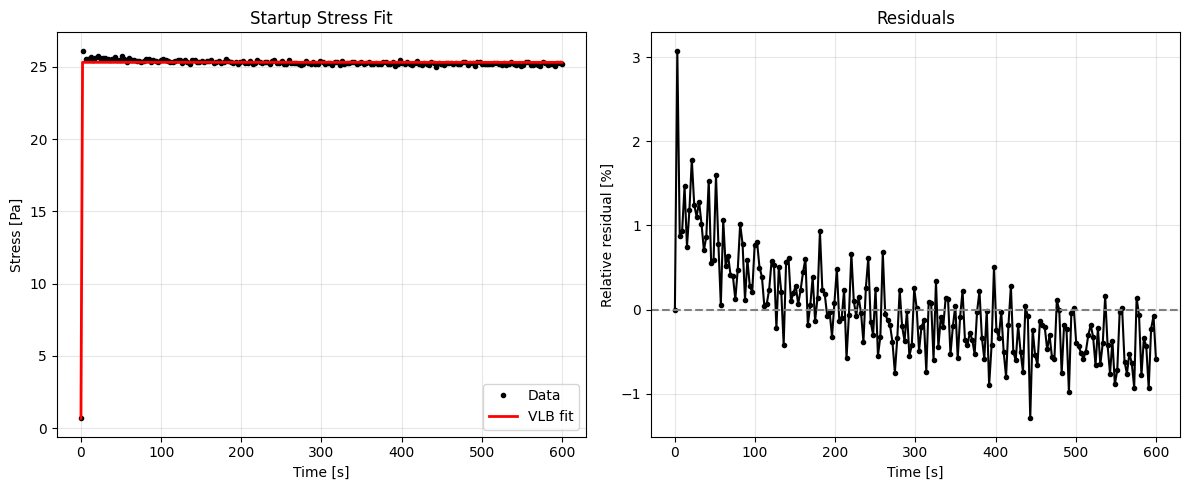

In [4]:
model = VLBLocal()

t0 = time.time()
model.fit(time_data, stress_data, test_mode='startup', gamma_dot=GAMMA_DOT)
t_nlsq = time.time() - t0

print(f'NLSQ fit time: {t_nlsq:.2f} s')
print(f'G0  = {model.G0:.2f} Pa')
print(f'k_d = {model.k_d:.4f} 1/s')
print(f'eta_0 = {model.G0 / model.k_d:.2f} Pa*s')
print(f'sigma_ss = {model.G0 / model.k_d * GAMMA_DOT:.2f} Pa')

# Fit quality
time_fine = np.linspace(time_data.min(), time_data.max(), 300)
stress_pred_fine = model.predict(time_fine, test_mode='startup', gamma_dot=GAMMA_DOT)
stress_pred = model.predict(time_data, test_mode='startup', gamma_dot=GAMMA_DOT)
ss_res = np.sum((stress_data - np.array(stress_pred))**2)
ss_tot = np.sum((stress_data - np.mean(stress_data))**2)
r2 = 1 - ss_res / ss_tot
print(f'R-squared = {r2:.6f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(time_data, stress_data, 'ko', markersize=3, label='Data')
ax1.plot(time_fine, stress_pred_fine, 'r-', lw=2, label='VLB fit')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Stress [Pa]')
ax1.set_title('Startup Stress Fit')
ax1.legend()
ax1.grid(True, alpha=0.3)

residuals = (stress_data - np.array(stress_pred)) / stress_data * 100
ax2.plot(time_data, residuals, 'ko-', markersize=3)
ax2.axhline(0, color='gray', ls='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Relative residual [%]')
ax2.set_title('Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Step 2: Bayesian Inference (NUTS)

In [5]:
config = get_bayesian_config()
initial_values = {'G0': float(model.G0), 'k_d': float(model.k_d)}
print(f'Config: {config}')
print(f'Warm-start: {initial_values}')

t0 = time.time()
result = model.fit_bayesian(
    time_data, stress_data, test_mode='startup',
    gamma_dot=GAMMA_DOT,
    initial_values=initial_values,
    seed=42,
    **config,
)
t_bayes = time.time() - t0
print(f'\nBayesian inference time: {t_bayes:.1f} s')

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}
Warm-start: {'G0': 130.94599862248978, 'k_d': 5.174135154419678}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<01:19,  1.86it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

sample:  51%|█████▏    | 77/150 [00:00<00:00, 160.90it/s, 255 steps of size 5.36e-03. acc. prob=0.97]

sample:  97%|█████████▋| 146/150 [00:00<00:00, 282.56it/s, 255 steps of size 5.36e-03. acc. prob=0.96]

sample: 100%|██████████| 150/150 [00:00<00:00, 202.23it/s, 23 steps of size 5.36e-03. acc. prob=0.96] 


Bayesian inference time: 2.6 s


## 5. Convergence Diagnostics

In [6]:
param_names = ["G0", "k_d"]
converged = print_convergence(result, param_names)

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
        G0    2.0449         3 *
       k_d    2.0453         3 *

Divergences: 0
Convergence: CHECK REQUIRED


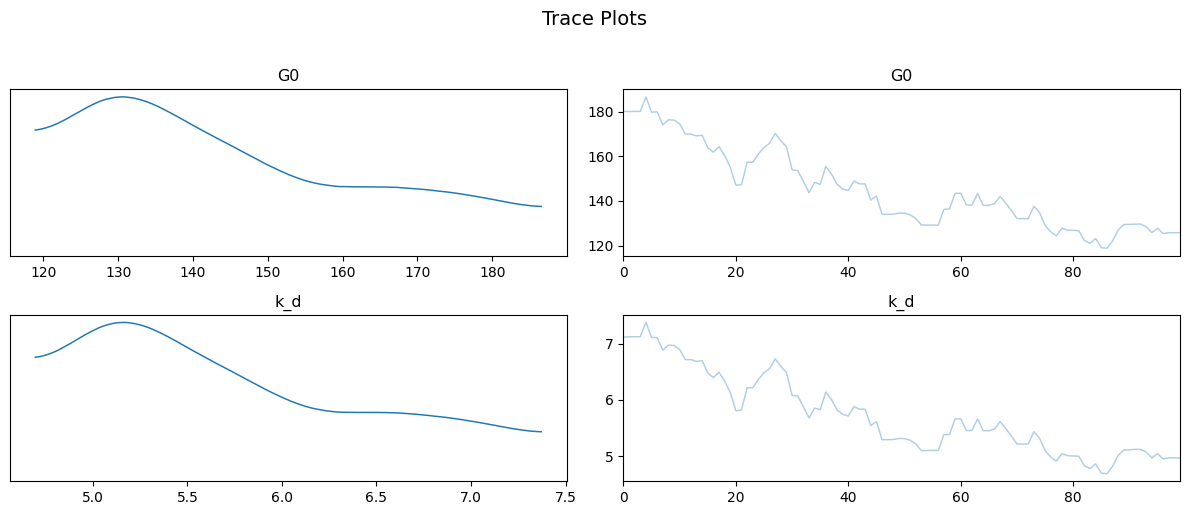

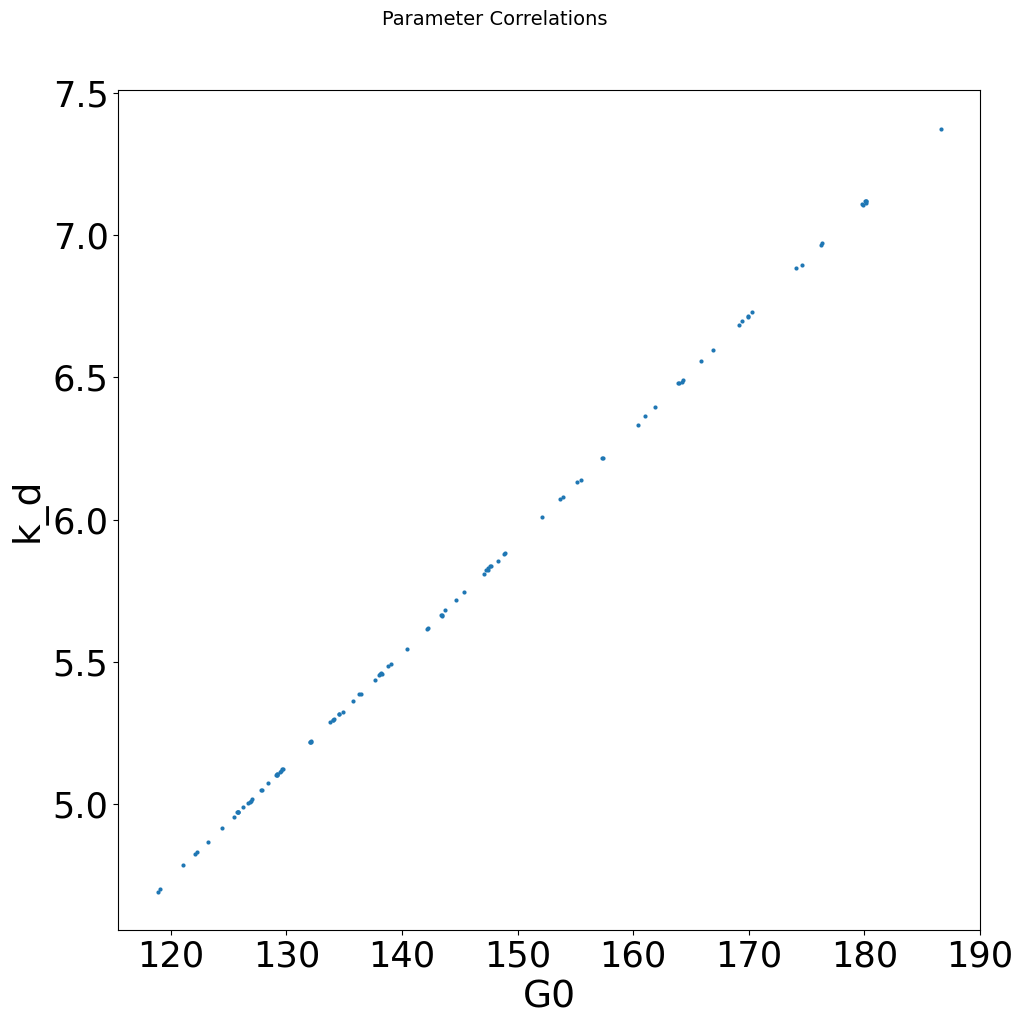

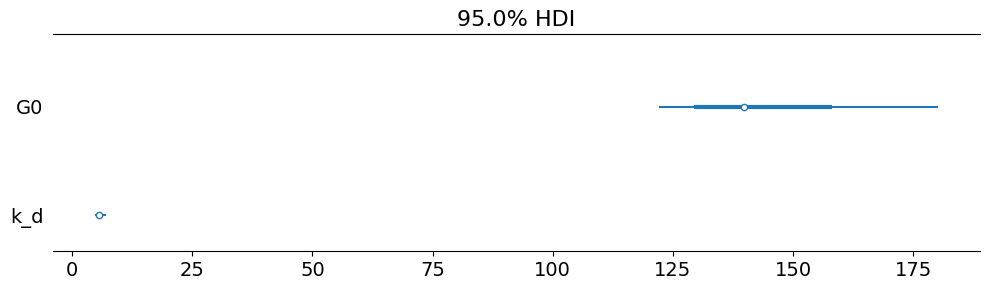

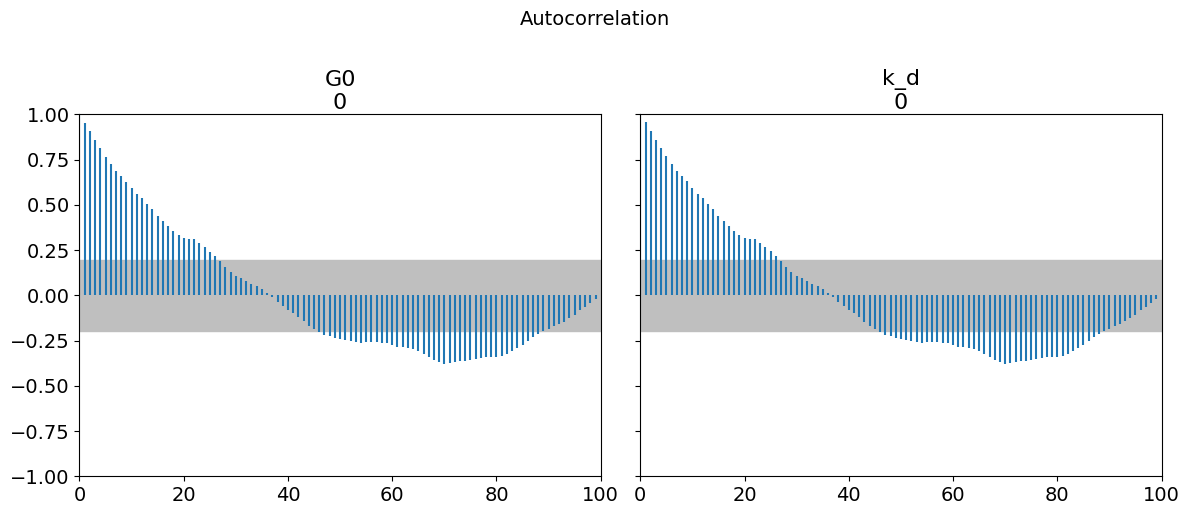

In [7]:
display_arviz_diagnostics(result, param_names, fast_mode=os.environ.get("FAST_MODE", "1") == "1")

## 6. Posterior Summary

In [8]:
posterior = result.posterior_samples
nlsq_vals = {"G0": model.G0, "k_d": model.k_d}
print_parameter_table(["G0", "k_d"], nlsq_vals, posterior)

Parameter Comparison
   Param        NLSQ  Bayes (median)                95% CI
----------------------------------------------------------
      G0       130.9           139.7  [121.6, 180.1]
     k_d       5.174            5.52  [4.804, 7.12]


## 7. Posterior Predictive Check

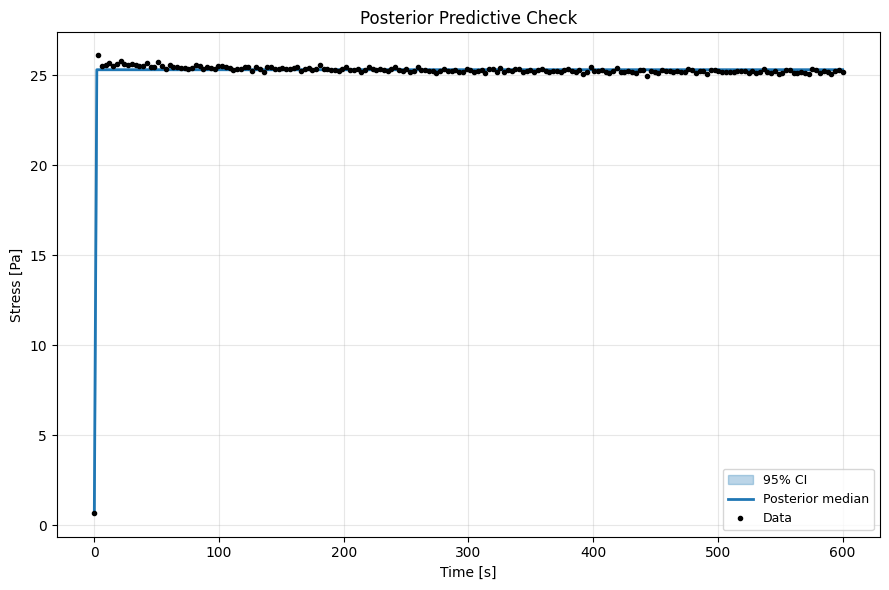

In [9]:
posterior = result.posterior_samples
n_draws = min(200, len(posterior['G0']))

stress_samples = []
for i in range(n_draws):
    model.parameters.set_value('G0', float(posterior['G0'][i]))
    model.parameters.set_value('k_d', float(posterior['k_d'][i]))
    stress_samples.append(np.array(
        model.predict(time_fine, test_mode='startup', gamma_dot=GAMMA_DOT)
    ))

stress_arr = np.array(stress_samples)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(time_fine,
    np.percentile(stress_arr, 2.5, axis=0),
    np.percentile(stress_arr, 97.5, axis=0),
    alpha=0.3, color='C0', label='95% CI')
ax.plot(time_fine, np.median(stress_arr, axis=0),
        'C0-', lw=2, label='Posterior median')
ax.plot(time_data, stress_data, 'ko', markersize=3, label='Data')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Stress [Pa]')
ax.set_title('Posterior Predictive Check')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Save Results

In [10]:
output_dir = get_output_dir("startup")
save_results(output_dir, model, result, ["G0", "k_d"], {"gamma_dot": GAMMA_DOT})
print("Done.")

Saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/vlb/startup/
Done.


## Key Takeaways

1. **Startup captures both G₀ and k_d** from transient approach to steady state
2. **No overshoot** in VLB — overshoot requires thixotropy or nonlinear stretching
3. **Steady-state stress** confirms $\eta_0 = G_0/k_d$ from flow curve
4. **Multiple shear rates** could be fitted simultaneously for tighter constraints

## Next

- **Notebook 15**: SAOS NLSQ → NUTS (best protocol for VLB)